In [4]:
import torch
from pdes import NeuralPDE,Siren,NN,batch_jacobian,InnerNeuralPDE
from torch.autograd import grad
from oil.utils.utils import Expression
import numpy as np

In [5]:
class Poisson(NeuralPDE):
    def __init__(self,*args,rho=(lambda x: 1),**kwargs):
        super().__init__(*args,**kwargs)
        self.rho=rho
        self.model.cuda()
    def sample_domain(self,N):
        return torch.rand(N,2)
    def sample_boundary(self,N):
        side = torch.randint(low=0,high=4,size=(N,))
        z = torch.rand(N)
        ones = torch.ones_like(z)
        upper = torch.stack([z,0*ones],dim=-1)
        lower = torch.stack([z,ones],dim=-1)
        left = torch.stack([0*ones,z],dim=-1)
        right = torch.stack([ones,z],dim=-1)
        all_sides = torch.stack([upper,lower,left,right],dim=0)
        return all_sides[side,torch.arange(N),:]
    def action(self,X,B):
        X = X.cuda()
        B=B.cuda()
        phi_B = self.model(B)
        phi = self.model(X)
        dphi = grad(phi.sum(),X,create_graph=True)[0]
        lagrangian = (dphi**2).sum(-1)/2 - phi*self.rho(X)/2
        boundary = (phi_B**2)
        return lagrangian.mean()+boundary.mean()
    def action(self,X,B):
        X = X.cuda()
        B=B.cuda()
        phi_B = self.model(B)
        #phi = self.model(X)
        dphi = lambda x: grad(self.model(x).sum(),x,create_graph=True)[0]
        Hphi = batch_jacobian(dphi,X,2)
        laplacian_phi = Hphi[...,0,0]+Hphi[...,1,1]
        pde_residual = (-laplacian_phi-self.rho(X))**2
        boundary_residual = phi_B**2
        return pde_residual.mean()+boundary_residual.mean()

In [78]:
class PoissonDisk(InnerNeuralPDE):
    def __init__(self,*args,rho=(lambda x: 1),**kwargs):
        super().__init__(*args,**kwargs)
        self.rho=rho
        self.model.cuda()
    def sample_domain(self,N):
        r = torch.rand(N).sqrt()
        theta = 2*np.pi*torch.rand(N)
        return torch.stack([r*theta.cos(),r*theta.sin()],dim=-1)
    def sample_boundary(self,N):
        x = torch.randn(N,2)
        return x/(x**2).sum(-1,keepdims=True).sqrt()
    def sample_inner_boundary(self,N):
        x = torch.randn(N,2)
        return .1*x/(x**2).sum(-1,keepdims=True).sqrt()
    def action(self,X,B,iX):
        X = X.cuda()
        B=B.cuda()
        iX = iX.cuda()
        phi = self.model(X)
        dphi = grad(phi.sum(),X,create_graph=True,retain_graph=True)[0]
        phi_B = self.model(B)
        lagrangian = (dphi**2).sum(-1)/2
        boundary = (phi_B**2)
        return lagrangian.mean()+100*boundary.mean()- self.model(iX).mean()

In [91]:
model = NN(L=4)#,k=256)#NN(L=4)#Siren(L=5)#
#model = Expression(lambda x: x[...,0]*(1-x[...,0])*x[...,1]*(1-x[...,1])*base_model(x))
opt = lambda params: torch.optim.Adam(params,lr=1e-3)#torch.optim.SGD(params,lr=1e-2,nesterov=True,momentum=.9)#torch.optim.Adam(params,lr=1e-4)
pde = PoissonDisk(model,opt,bs=10000)#,lr_sched=lambda e: 1/(1+e/20))

In [92]:
#pde.model(pde.sample_boundary(100))

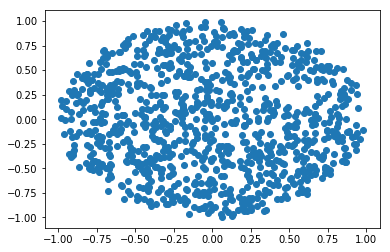

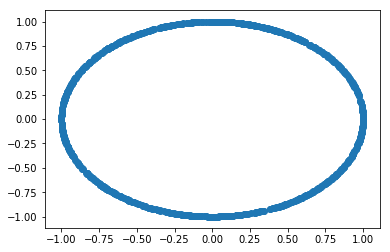

In [93]:
import matplotlib.pyplot as plt
plt.scatter(*pde.sample_domain(1000).T.data.numpy())
plt.show()
plt.scatter(*pde.sample_boundary(1000).T.data.numpy())
plt.show()

In [94]:
pde.solve(1000)

       loss
0  0.081103
        loss
21  1.148883
        loss
42  0.047507
        loss
63 -0.016085
        loss
84 -0.034964
         loss
105 -0.052056
        loss
126 -0.07737
         loss
147 -0.115407
         loss
168 -0.169229
         loss
189 -0.229531
        loss
210 -0.25679
         loss
231 -0.259548
         loss
252 -0.264058
         loss
273 -0.268248
         loss
294 -0.271328
        loss
315 -0.28046
         loss
336 -0.292378
         loss
357 -0.317351
         loss
378 -0.356375
         loss
399 -0.419589
         loss
420 -0.478638
         loss
441 -0.504943
         loss
462 -0.524964
         loss
483 -0.529652
         loss
504 -0.538954
         loss
525 -0.534245
         loss
546 -0.537949
        loss
567 -0.53403
         loss
588 -0.549346
         loss
609 -0.521586
         loss
630 -0.552364
         loss
651 -0.550501
         loss
672 -0.543077
         loss
693 -0.537439
         loss
714 -0.536781
         loss
735 -0.535693
         los

In [95]:
pde.model.cuda()
pde.model(pde.sample_boundary(100).cuda())

tensor([0.0069, 0.0073, 0.0072, 0.0064, 0.0064, 0.0071, 0.0072, 0.0063, 0.0067,
        0.0080, 0.0071, 0.0093, 0.0072, 0.0056, 0.0080, 0.0072, 0.0056, 0.0071,
        0.0079, 0.0075, 0.0096, 0.0076, 0.0067, 0.0065, 0.0078, 0.0073, 0.0080,
        0.0084, 0.0072, 0.0096, 0.0084, 0.0073, 0.0058, 0.0078, 0.0074, 0.0072,
        0.0082, 0.0092, 0.0064, 0.0065, 0.0056, 0.0071, 0.0078, 0.0097, 0.0067,
        0.0095, 0.0075, 0.0071, 0.0072, 0.0077, 0.0064, 0.0068, 0.0091, 0.0086,
        0.0070, 0.0082, 0.0096, 0.0066, 0.0077, 0.0077, 0.0078, 0.0089, 0.0078,
        0.0067, 0.0080, 0.0065, 0.0073, 0.0078, 0.0058, 0.0056, 0.0072, 0.0081,
        0.0096, 0.0077, 0.0085, 0.0068, 0.0073, 0.0069, 0.0077, 0.0077, 0.0076,
        0.0057, 0.0069, 0.0093, 0.0095, 0.0060, 0.0080, 0.0076, 0.0068, 0.0069,
        0.0067, 0.0095, 0.0062, 0.0083, 0.0081, 0.0065, 0.0085, 0.0064, 0.0081,
        0.0093], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [96]:
pde.model(pde.sample_domain(100).cuda())

tensor([0.2831, 0.7962, 0.4050, 0.0911, 0.0778, 0.1512, 0.1275, 0.1157, 0.0444,
        0.2817, 0.1576, 0.2450, 0.4543, 0.0653, 0.2673, 0.0438, 0.7741, 0.1734,
        0.3424, 0.2788, 0.7030, 0.7321, 0.0773, 0.5658, 0.1457, 0.3319, 0.1432,
        0.1392, 0.6720, 0.1835, 0.2416, 0.2452, 0.0289, 0.4046, 0.2253, 0.5182,
        0.3363, 0.0428, 0.2712, 0.0964, 0.8007, 0.2432, 0.1799, 0.7788, 0.0748,
        0.6965, 0.2906, 0.0216, 0.1568, 0.0624, 0.2085, 0.1393, 0.0135, 0.7562,
        0.3246, 0.2879, 0.1668, 0.2755, 0.2213, 0.7011, 0.1189, 0.6522, 0.0680,
        0.8353, 0.3291, 0.0486, 0.1997, 0.3466, 0.1095, 0.2832, 0.0706, 0.4710,
        0.1297, 0.0638, 0.1166, 0.0252, 0.2830, 0.0850, 0.0664, 0.1552, 0.6644,
        0.0199, 0.5731, 0.2862, 0.2125, 0.1324, 0.0995, 0.0284, 0.5635, 1.2005,
        0.1825, 0.0257, 0.6309, 0.0170, 0.7465, 0.0726, 0.1463, 0.1815, 0.1865,
        0.0394], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [97]:
xy = torch.stack(torch.meshgrid(torch.linspace(0,1,200),torch.linspace(0,1,200)),dim=-1)

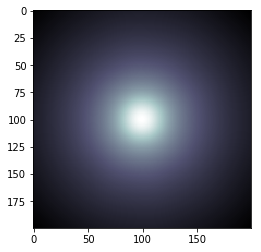

In [98]:
xy = torch.stack(torch.meshgrid(torch.linspace(-1,1,200),torch.linspace(-1,1,200)),dim=-1)
import matplotlib.pyplot as plt
pde.model.cpu()
z = pde.model(xy.reshape(-1,2)).data.numpy().reshape(200,200)
plt.imshow(z,cmap='bone')
plt.show()

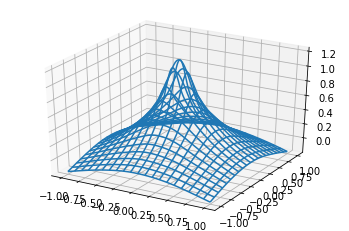

In [99]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
x=0 or 1 phi=0 or y=0 or 1 phi=0
Phi = x*(1-x)*y*(1-y)*NN(x,y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
ax.plot_wireframe(*xy.data.numpy().T, z, rstride=10, cstride=10)
plt.show()

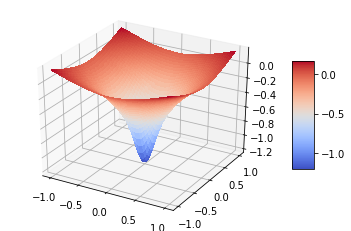

In [100]:
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(*xy.data.numpy().T, -z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

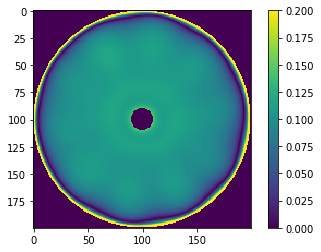

In [101]:
nxy = xy.data.numpy().T
z_gt = -np.log(nxy[0]**2+nxy[1]**2)/(np.pi)
err = np.abs(z-z_gt)/(np.abs(z_gt)+np.abs(z))
err[((nxy**2).sum(0)>1)|((nxy**2).sum(0)<.01)]=0
plt.imshow(err,vmin=0,vmax=.2)
plt.colorbar()


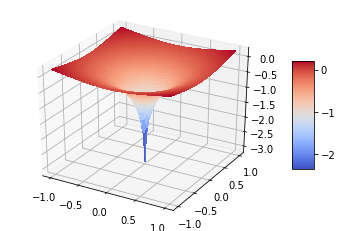

In [27]:
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
nxy = xy.data.numpy().T
surf = ax.plot_surface(*nxy, np.log(nxy[0]**2+nxy[1]**2)/(np.pi), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [28]:
pde.model(torch.tensor([0.,.5])[None])

tensor([0.0624], grad_fn=<SqueezeBackward1>)

In [31]:
import matplotlib.pyplot as plt
plt.scatter(*all_sides[:,torch.arange(N),side])
plt.show()

NameError: name 'all_sides' is not defined

In [5]:
torch.linspace(0,1,10).repeat(2,1).shape

torch.Size([2, 10])

In [ ]:
import torch
torch.arange(12).reshape(2,3,4)

In [ ]:
import torch